# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpllimg
import seaborn as sns

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# Datas

In [4]:
# Load colums in dataframes for each dataset
df_train = pd.read_csv('../train.csv')
df_test = pd.read_csv('../test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (1790594, 17)
Test shape: (146853, 3)


In [5]:
len(df_train['StudyInstanceUID'].unique())

7279

In [6]:
# Info about datas
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790594 entries, 0 to 1790593
Data columns (total 17 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   StudyInstanceUID            object
 1   SeriesInstanceUID           object
 2   SOPInstanceUID              object
 3   pe_present_on_image         int64 
 4   negative_exam_for_pe        int64 
 5   qa_motion                   int64 
 6   qa_contrast                 int64 
 7   flow_artifact               int64 
 8   rv_lv_ratio_gte_1           int64 
 9   rv_lv_ratio_lt_1            int64 
 10  leftsided_pe                int64 
 11  chronic_pe                  int64 
 12  true_filling_defect_not_pe  int64 
 13  rightsided_pe               int64 
 14  acute_and_chronic_pe        int64 
 15  central_pe                  int64 
 16  indeterminate               int64 
dtypes: int64(14), object(3)
memory usage: 232.2+ MB


In [7]:
# Some examples 
df_train.head(n=10)

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0
5,6897fa9de148,2bfbb7fd2e8b,c7b99cb454d4,0,0,0,0,0,0,1,1,0,0,1,0,0,0
6,6897fa9de148,2bfbb7fd2e8b,e153deb813ed,0,0,0,0,0,0,1,1,0,0,1,0,0,0
7,6897fa9de148,2bfbb7fd2e8b,c6bbe08f2736,0,0,0,0,0,0,1,1,0,0,1,0,0,0
8,6897fa9de148,2bfbb7fd2e8b,09886998dc28,0,0,0,0,0,0,1,1,0,0,1,0,0,0
9,6897fa9de148,2bfbb7fd2e8b,5b5226ac7bac,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [8]:
# Pack dependant features in one categorical feature

# Merge 2 ratio features in a single one
ratio_mask = [x == 1 for x in df_train['rv_lv_ratio_gte_1']]
df_train['rv_lv_ratio'] = pd.Categorical(np.where(ratio_mask, ">=1", "<1"))

# Merge pe type related features in a signle one

# Take chronic and acute+chronic
def categorize_pe_type(data):
    if data['chronic_pe']: return "Chronic"
    elif data['acute_and_chronic_pe']: return "Acute and Chronic"
    else: return "Acute"
    
    
df_train['pe_type'] = pd.Categorical(df_train.apply(categorize_pe_type, axis=1))

In [9]:
# Remove packed features

# TODO add asserts to ensure a good behavior before dropping
df_train.drop(['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1'], axis=1, inplace=True)
df_train.drop(['chronic_pe','acute_and_chronic_pe'], axis=1, inplace=True)

In [10]:
# Show dataframe's info with new features
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790594 entries, 0 to 1790593
Data columns (total 15 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   StudyInstanceUID            object  
 1   SeriesInstanceUID           object  
 2   SOPInstanceUID              object  
 3   pe_present_on_image         int64   
 4   negative_exam_for_pe        int64   
 5   qa_motion                   int64   
 6   qa_contrast                 int64   
 7   flow_artifact               int64   
 8   leftsided_pe                int64   
 9   true_filling_defect_not_pe  int64   
 10  rightsided_pe               int64   
 11  central_pe                  int64   
 12  indeterminate               int64   
 13  rv_lv_ratio                 category
 14  pe_type                     category
dtypes: category(2), int64(10), object(3)
memory usage: 181.0+ MB


In [11]:
# Show samples 
df_train.head(n=10)

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,leftsided_pe,true_filling_defect_not_pe,rightsided_pe,central_pe,indeterminate,rv_lv_ratio,pe_type
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,1,0,1,0,0,<1,Acute
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,1,0,1,0,0,<1,Acute
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,1,0,1,0,0,<1,Acute
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,1,0,1,0,0,<1,Acute
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,1,0,1,0,0,<1,Acute
5,6897fa9de148,2bfbb7fd2e8b,c7b99cb454d4,0,0,0,0,0,1,0,1,0,0,<1,Acute
6,6897fa9de148,2bfbb7fd2e8b,e153deb813ed,0,0,0,0,0,1,0,1,0,0,<1,Acute
7,6897fa9de148,2bfbb7fd2e8b,c6bbe08f2736,0,0,0,0,0,1,0,1,0,0,<1,Acute
8,6897fa9de148,2bfbb7fd2e8b,09886998dc28,0,0,0,0,0,1,0,1,0,0,<1,Acute
9,6897fa9de148,2bfbb7fd2e8b,5b5226ac7bac,0,0,0,0,0,1,0,1,0,0,<1,Acute


In [12]:
# Method to find features values of one image given its id
def imageFeatures(id):
    return df_train.loc[df_train['SOPInstanceUID'] == id]

In [14]:
# Builds the list of images IDs available in the given directory
def listAvailableImages(directory, extension):
    return list(map(lambda x: x.split(extension)[0], os.listdir(directory)))


available_images = listAvailableImages('../images', '.jpg')

In [19]:
# Only keep available images rows
def cleanUpDataframe(df):
    return df.loc[df_train['SOPInstanceUID'].isin(available_images)]
    

df_train_clean = cleanUpDataframe(df_train)
len(df_train_clean['StudyInstanceUID'].unique())

229

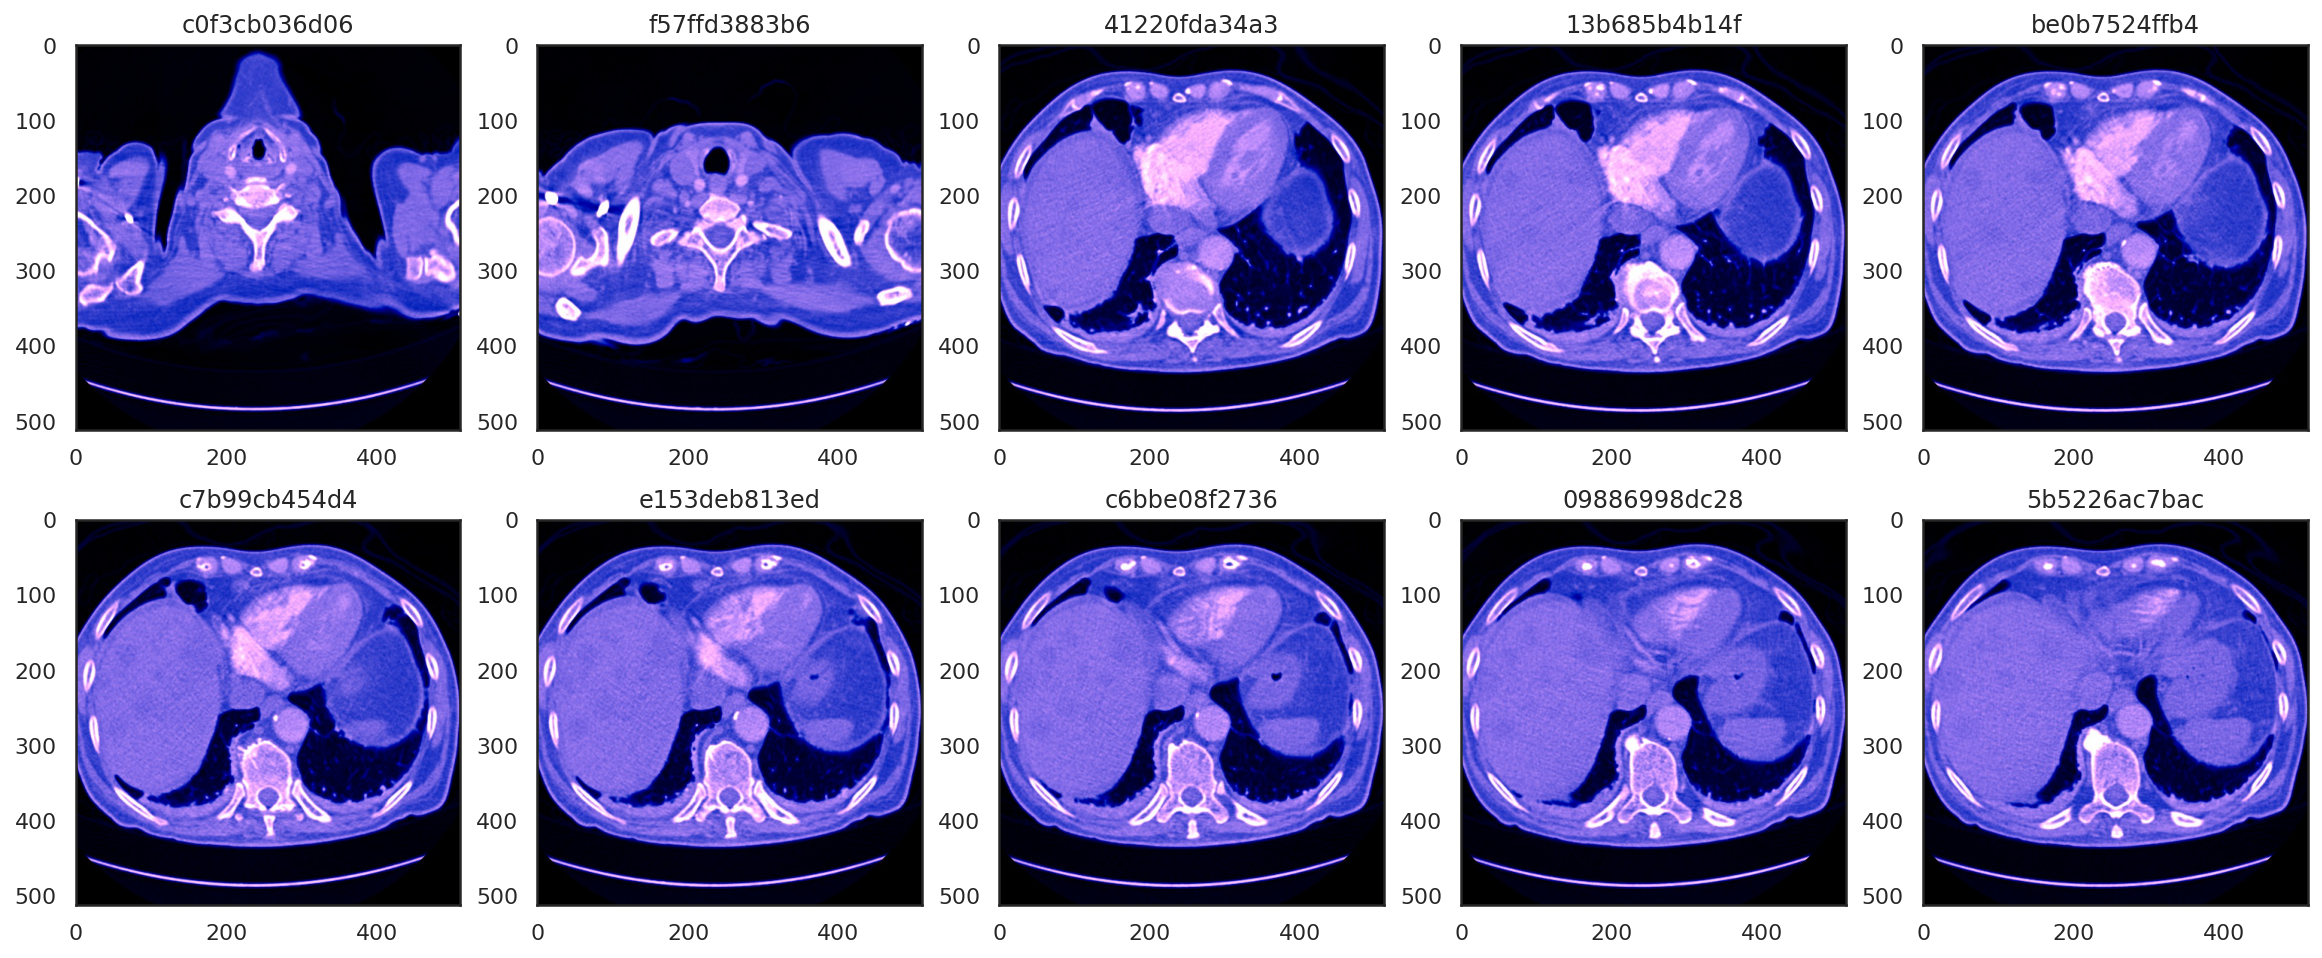

In [16]:
# Show the n first images of the dataset
def showHead(df, n=5):
    
    with sns.axes_style("white"): 
        plt.figure(figsize=(20, 8))
        for i, code in enumerate(df['SOPInstanceUID'][:n]):
            fig = plt.subplot(2, 5, i + 1)
            plt.imshow(mpllimg.imread('../images/' + code + '.jpg'), cmap=plt.cm.binary)
            plt.title(code)
        
        
showHead(df_train_clean, n=10)

In [ ]:
im = plt.imread('./images/' + os.listdir('./images/')[0])

print(np.unique(im[:,:,0]))
print(np.unique(im[:,:,1]))
print(np.unique(im[:,:,2]))
print(np.unique(im))
print(im.shape)